In [99]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, auc
import xgboost as xgb
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from keras.losses import BinaryCrossentropy
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv(r"aicsdata.csv")

In [3]:
df.head()

,Time,Protcol,Flag,Family,Clusters,SeddAddress,ExpAddress,BTC,USD,Netflow_Bytes,IPaddress,Threats,Port,Prediction
0,50,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,500,5,A,Bonet,5061,SS
1,40,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,504,8,A,Bonet,5061,SS
2,30,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,508,7,A,Bonet,5061,SS
3,20,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,512,15,A,Bonet,5061,SS
4,57,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,516,9,A,Bonet,5061,SS


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149043 entries, 0 to 149042
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Time           149043 non-null  int64 
 1   Protcol        149043 non-null  object
 2   Flag           149043 non-null  object
 3   Family         149043 non-null  object
 4   Clusters       149043 non-null  int64 
 5   SeddAddress    149043 non-null  object
 6   ExpAddress     149043 non-null  object
 7   BTC            149043 non-null  int64 
 8   USD            149043 non-null  int64 
 9   Netflow_Bytes  149043 non-null  int64 
 10  IPaddress      149043 non-null  object
 11  Threats        149043 non-null  object
 12  Port           149043 non-null  int64 
 13  Prediction     149043 non-null  object
dtypes: int64(6), object(8)
memory usage: 15.9+ MB


# DATA CLEANING
---

In [5]:
# Get number of null values

df.isnull().sum()

Time             0
Protcol          0
Flag             0
Family           0
Clusters         0
SeddAddress      0
ExpAddress       0
BTC              0
USD              0
Netflow_Bytes    0
IPaddress        0
Threats          0
Port             0
Prediction       0
dtype: int64

In [6]:
# Rename 'Protcol' Column to 'Protocol'
df = df.rename(columns={'Protcol' : 'Protocol'})
df.head()

,Time,Protocol,Flag,Family,Clusters,SeddAddress,ExpAddress,BTC,USD,Netflow_Bytes,IPaddress,Threats,Port,Prediction
0,50,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,500,5,A,Bonet,5061,SS
1,40,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,504,8,A,Bonet,5061,SS
2,30,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,508,7,A,Bonet,5061,SS
3,20,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,512,15,A,Bonet,5061,SS
4,57,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,516,9,A,Bonet,5061,SS


In [7]:
# Rename 'Bonet' to 'Botnet' in 'Threats' Column
print("BEFORE RENAMING:")
print(df['Threats'].unique())

df['Threats'] = df['Threats'].str.replace('Bonet', 'Botnet')

print("\n\nAFTER RENAMING:")
print(df['Threats'].unique())

BEFORE RENAMING:
['Bonet' 'DoS' 'Spam' 'Blacklist' 'SSH' 'UDP Scan' 'Scan' 'NerisBonet'
 'Port Scanning']


AFTER RENAMING:
['Botnet' 'DoS' 'Spam' 'Blacklist' 'SSH' 'UDP Scan' 'Scan' 'NerisBotnet'
 'Port Scanning']


In [8]:
# Drop duplicate rows
before = df.shape[0]
df = df.drop_duplicates()
after  = df.shape[0]
print(f"Number of Duplicate Rows: {before - after} = [{before} - {after}]")

Number of Duplicate Rows: 0 = [149043 - 149043]


In [9]:
# Ensure timestamp field is non-negative

print(f"Minimum Value of Timestamp (originally): {df['Time'].min()}")
df['Time'] = df['Time'] + abs(df['Time'].unique().min()) + 1
print(f"Minimum Value of Timestamp (Post-Processed): {df['Time'].min()}")

Minimum Value of Timestamp (originally): -10
Minimum Value of Timestamp (Post-Processed): 1


In [10]:
# Removal of features irrelevant for anomaly detection

df = df.drop(columns=['SeddAddress', 'ExpAddress', 'Port'])
df.head()

,Time,Protocol,Flag,Family,Clusters,BTC,USD,Netflow_Bytes,IPaddress,Threats,Prediction
0,61,TCP,A,WannaCry,1,1,500,5,A,Botnet,SS
1,51,TCP,A,WannaCry,1,1,504,8,A,Botnet,SS
2,41,TCP,A,WannaCry,1,1,508,7,A,Botnet,SS
3,31,TCP,A,WannaCry,1,1,512,15,A,Botnet,SS
4,68,TCP,A,WannaCry,1,1,516,9,A,Botnet,SS


In [11]:
# Save the cleaned data into a new csv for processing
df.to_csv(r"aicsdata_cleaned.csv", index=False)
print("Cleaned Data saved to CSV file named 'aicsdata_cleaned.csv'!")

Cleaned Data saved to CSV file named 'aicsdata_cleaned.csv'!


# DATA TRANSFORMATION
---

In [12]:
df_transformed = df

In [13]:
# Normalize Numerical Columns
def normalize_columns(numerical_columns):
    for column in numerical_columns:
        print(f"COLUMN NAME: '{column}'")
        counter = 1
        while True:
            print(f"\n|---ITERATION {counter}---|")
            severity, skewness = apply_transformation_technique(column)
            if severity == "Normal":
                print(f"\n|---Final Skewness: {skewness}")
                break
            counter += 1
            if (counter > 3):
                print(f"|--- Maximum Iterations Reached! Transformations Stopped!!!\n\n")
                break
        column_histogram(column)

# method to determine appropriate transformation technique
def apply_transformation_technique(column):
    # Get significance and direction of skewness
    skewness, severity, direction = identify_skewness(column)
    print(f"|---skewness: {skewness}")
    print(f"|---{severity}, {direction}")
    
    if severity == "Mild":
        if direction == "Right":
            print(f"|---Square Root Transformation Applied!")
            df_transformed[column] = np.sqrt(df_transformed[column])
        elif direction == "Left":
            if (df_transformed[column] < 0).any():
                print(f"|---Yeo-Johnson Transformation Applied!")
                pt = PowerTransformer(method="yeo-johnson")
                df_transformed[column] = pt.fit_transform(df_transformed[column])
            else:
                print(f"|---Squaring Transformation Applied!")
                df_transformed[column] = df_transformed[column] ** 2
    elif severity == "High":
            print(f"|---Log Transformation Applied!")
            if (df_transformed[column] < 0).any():
                K = df_transformed[column].max() + 1
                df_transformed[column] = np.log1p(K - df_transformed[column])
            else:
                df_transformed[column] = np.log1p(df_transformed[column])
    
    skewness, severity, direction = identify_skewness(column)

    # column_histogram(column)
    
    return severity, skewness

# method to check for skewness in numerical columns
def identify_skewness(column):
    # threshold for skewness analysis
    threshold = 0.5
    # Analyze skewness
    skewness = df_transformed[column].skew()
    severity  = "High" if abs(skewness) > 1 else "Mild" if abs(skewness) > 0.5 else "Normal" 
    direction = "Right" if skewness > 0 else "Left"
    return skewness, severity, direction

# method for visualizing a distribution as histogram
def column_histogram(column):
    # Plot histogram
    plt.figure(figsize=(8,5))
    sns.histplot(df_transformed[column], bins=10, kde=True)
    plt.title(f"Histogram of {column}")
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.show()

COLUMN NAME: 'BTC'

|---ITERATION 1---|
|---skewness: 11.936408891727332
|---High, Right
|---Log Transformation Applied!

|---ITERATION 2---|
|---skewness: 0.8396954213602023
|---Mild, Right
|---Square Root Transformation Applied!

|---Final Skewness: 0.08610365301338582


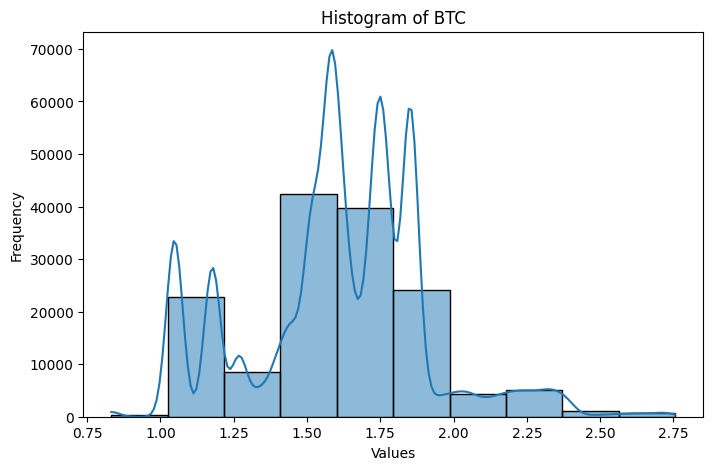

COLUMN NAME: 'USD'

|---ITERATION 1---|
|---skewness: 3.231839401850607
|---High, Right
|---Log Transformation Applied!

|---ITERATION 2---|
|---skewness: -1.0486269611707062
|---High, Left
|---Log Transformation Applied!

|---ITERATION 3---|
|---skewness: -1.9181332487447156
|---High, Left
|---Log Transformation Applied!
|--- Maximum Iterations Reached! Transformations Stopped!!!




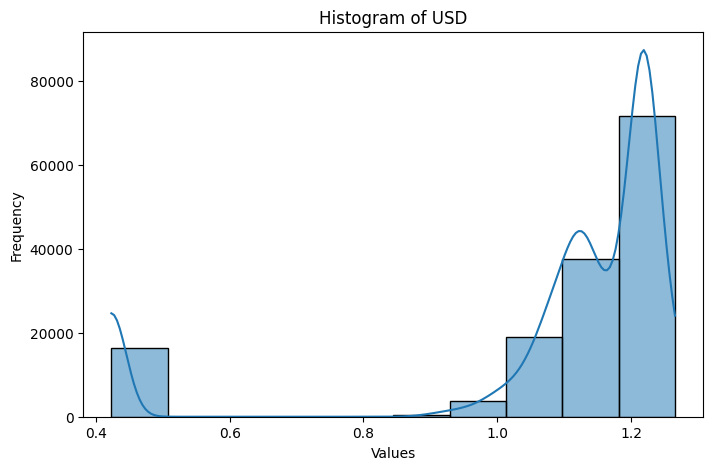

COLUMN NAME: 'Netflow_Bytes'

|---ITERATION 1---|
|---skewness: 1.5736884427761342
|---High, Right
|---Log Transformation Applied!

|---ITERATION 2---|
|---skewness: -0.6289348341784531
|---Mild, Left
|---Squaring Transformation Applied!

|---Final Skewness: -0.11305518247412043


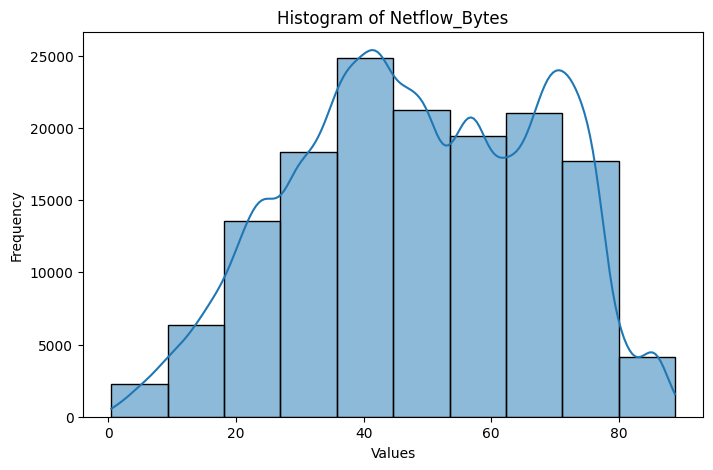

In [14]:
normalize_columns(('BTC', 'USD', 'Netflow_Bytes'))

In [15]:
df_transformed.head()

,Time,Protocol,Flag,Family,Clusters,BTC,USD,Netflow_Bytes,IPaddress,Threats,Prediction
0,61,TCP,A,WannaCry,1,0.832555,1.090709,3.210402,A,Botnet,SS
1,51,TCP,A,WannaCry,1,0.832555,1.091079,4.827796,A,Botnet,SS
2,41,TCP,A,WannaCry,1,0.832555,1.091446,4.324077,A,Botnet,SS
3,31,TCP,A,WannaCry,1,0.832555,1.091809,7.687248,A,Botnet,SS
4,68,TCP,A,WannaCry,1,0.832555,1.092169,5.301898,A,Botnet,SS


In [16]:
# Save the transformed data into a new csv for processing
df_transformed.to_csv(r"aicsdata_transformed.csv", index=False)
print("Transformed Data saved to CSV file named 'aicsdata_transformed.csv'!")

Transformed Data saved to CSV file named 'aicsdata_transformed.csv'!


# FEATURE ENGINEERING
---

In [17]:
# Utilize the transformed data
df = pd.read_csv(r"aicsdata_transformed.csv")

In [18]:
df.head()

,Time,Protocol,Flag,Family,Clusters,BTC,USD,Netflow_Bytes,IPaddress,Threats,Prediction
0,61,TCP,A,WannaCry,1,0.832555,1.090709,3.210402,A,Botnet,SS
1,51,TCP,A,WannaCry,1,0.832555,1.091079,4.827796,A,Botnet,SS
2,41,TCP,A,WannaCry,1,0.832555,1.091446,4.324077,A,Botnet,SS
3,31,TCP,A,WannaCry,1,0.832555,1.091809,7.687248,A,Botnet,SS
4,68,TCP,A,WannaCry,1,0.832555,1.092169,5.301898,A,Botnet,SS


In [19]:
# Find cardinality of categorical features
categorical_cols = df.select_dtypes(include = "object").columns
categorical_cols = categorical_cols.delete(len(categorical_cols) - 1)       # Remove 'Prediction' variable
print(categorical_cols)
print("\n")

for column in categorical_cols:
    print(f"CARDINALITY OF {column}: ", len(df[column].unique()))

Index(['Protocol', 'Flag', 'Family', 'IPaddress', 'Threats'], dtype='object')


CARDINALITY OF Protocol:  3
CARDINALITY OF Flag:  9
CARDINALITY OF Family:  17
CARDINALITY OF IPaddress:  4
CARDINALITY OF Threats:  9


In [20]:
# Separate target and features
X = df.drop(columns=['Prediction'])
y = df['Prediction']

In [21]:
# Apply OneHotEncoder to categorical features
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop=None, sparse=False), categorical_cols)
    ],
    remainder='passthrough'  # Keep numerical columns as-is
)

In [22]:
X_encoded = column_transformer.fit_transform(X)

C:\Users\HP\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [23]:
encoded_feature_names = column_transformer.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_feature_names)

In [24]:
# Save the encoded feature data into a new csv for processing
X_encoded_df.to_csv(r"aicsdata_feature_encoded.csv", index=False)
print("Encoded Feature Data saved to CSV file named 'aicsdata_features_encoded.csv'!")

Encoded Feature Data saved to CSV file named 'aicsdata_features_encoded.csv'!


In [25]:
# Encode target: A → 0, S → 1, SS → 2
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [26]:
y_encoded_df = pd.DataFrame(y_encoded, columns=['Prediction'])

In [27]:
# Save the encoded target data into a new csv for processing
X_encoded_df.to_csv(r"aicsdata_target_encoded.csv", index=False)
print("Encoded target Data saved to CSV file named 'aicsdata_target_encoded.csv'!")

Encoded target Data saved to CSV file named 'aicsdata_target_encoded.csv'!


# HYBRID MODEL (AUTOENCODER + XGBOOST)
---

In [100]:
# Normalize numeric features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [101]:
# Split into normal (S/SS) and anomaly (A)
normal_mask = (y == 'S') | (y == 'SS')
anomaly_mask = (y == 'A')

X_normal = X_scaled[normal_mask]
X_anomaly = X_scaled[anomaly_mask]
y_normal = y_encoded[normal_mask]
y_anomaly = y_encoded[anomaly_mask]

In [102]:
# Split normal data into train and test
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(
    X_normal, y_normal, test_size=0.2, random_state=42)

## AUTOENCODER

In [103]:
# AutoEncoder for Anomaly Detection

# def build_autoencoder(input_dim):
#     input_layer = Input(shape=(input_dim,))
#     encoded = Dense(128, activation='relu')(input_layer)
#     encoded = Dense(64, activation='relu')(encoded)

#     bottleneck = Dense(16, activation='relu')(encoded)

#     decoded = Dense(64, activation='relu')(bottleneck)
#     decoded = BatchNormalization()(decoded)
#     # decoded = Dropout(0.2)(decoded)

#     decoded = Dense(128, activation='relu')(decoded)
#     decoded = BatchNormalization()(decoded)
#     # decoded = Dropout(0.2)(decoded)

#     output_layer = Dense(input_dim, activation='sigmoid')(decoded)
    
#     model = Model(input_layer, output_layer)
#     model.compile(optimizer=Adam(), loss='mae')
#     return model

def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    
    # Encoder
    encoded = Dense(128, kernel_regularizer=l2(1e-4))(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU()(encoded)
    
    encoded = Dense(64, kernel_regularizer=l2(1e-4))(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = LeakyReLU()(encoded)
    
    # Bottleneck
    bottleneck = Dense(8, kernel_regularizer=l2(1e-4))(encoded)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = LeakyReLU()(bottleneck)
    
    # Decoder
    decoded = Dense(64, kernel_regularizer=l2(1e-4))(bottleneck)
    decoded = BatchNormalization()(decoded)
    decoded = LeakyReLU()(decoded)
    decoded = Dropout(0.2)(decoded)
    
    decoded = Dense(128, kernel_regularizer=l2(1e-4))(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = LeakyReLU()(decoded)
    decoded = Dropout(0.2)(decoded)

    output_layer = Dense(input_dim, activation='sigmoid')(decoded)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-3), loss=BinaryCrossentropy())  # Use MSE for reconstruction
    
    return model



In [104]:
autoencoder = build_autoencoder(X_train_norm.shape[1])
autoencoder.fit(X_train_norm, X_train_norm, epochs=50, batch_size=256, validation_split=0.1, verbose=1)

Epoch 1/50
300/300 [==============================] - 3s 4ms/step - loss: 0.2452 - val_loss: 0.2044
Epoch 2/50
300/300 [==============================] - 1s 4ms/step - loss: 0.1337 - val_loss: 0.1243
Epoch 3/50
300/300 [==============================] - 1s 3ms/step - loss: 0.1102 - val_loss: 0.0946
Epoch 4/50
300/300 [==============================] - 1s 3ms/step - loss: 0.0978 - val_loss: 0.0795
Epoch 5/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0900 - val_loss: 0.0723
Epoch 6/50
300/300 [==============================] - 2s 6ms/step - loss: 0.0846 - val_loss: 0.0683
Epoch 7/50
300/300 [==============================] - 2s 8ms/step - loss: 0.0805 - val_loss: 0.0649
Epoch 8/50
300/300 [==============================] - 2s 7ms/step - loss: 0.0778 - val_loss: 0.0626
Epoch 9/50
300/300 [==============================] - 2s 6ms/step - loss: 0.0754 - val_loss: 0.0612
Epoch 10/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0732 - val_loss: 0.0599

In [128]:
# Predict reconstructed values
reconstructed_norm = autoencoder.predict(X_test_norm)
reconstructed_anom = autoencoder.predict(X_anomaly)

# Calculate reconstruction errors
error_norm = np.mean(np.square(X_test_norm - reconstructed_norm), axis=1)
error_anom = np.mean(np.square(X_anomaly - reconstructed_anom), axis=1)

1331/1331 [==============================] - 1s 661us/step


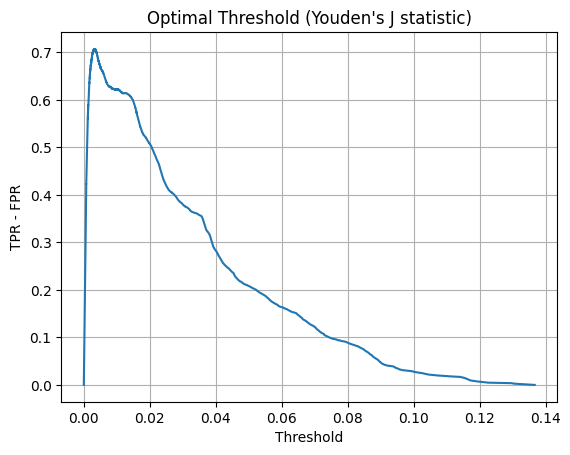

Optimized Threshold: 0.003306330947219317
Recall-optimized Threshold: 0.0004907107157161215


In [142]:
# find optimized threshold
y_true = np.concatenate([np.zeros_like(error_norm), np.ones_like(error_anom)])
y_scores = np.concatenate([error_norm, error_anom])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.plot(thresholds, tpr - fpr)
plt.xlabel("Threshold")
plt.ylabel("TPR - FPR")
plt.title("Optimal Threshold (Youden's J statistic)")
plt.grid()
plt.show()

best_thresh = thresholds[np.argmax(tpr - fpr)]
print("Optimized Threshold:", best_thresh)

# Example: Choose threshold where TPR >= 0.9 (90% recall)
target_tpr = 0.99
idx = np.where(tpr >= target_tpr)[0]

if len(idx) > 0:
    selected_idx = idx[0]  # First threshold where TPR ≥ 0.9
    recall_optimized_thresh = thresholds[selected_idx]
    print("Recall-optimized Threshold:", recall_optimized_thresh)
else:
    print("No threshold found for desired TPR")


Anomaly threshold: 0.0004907107157161215
Normal threshold: 0.013475307352592197

Autoencoder Performance:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     21297
         1.0       0.99      0.99      0.99     42561

    accuracy                           0.99     63858
   macro avg       0.99      0.99      0.99     63858
weighted avg       0.99      0.99      0.99     63858

Confusion Matrix for AutoEncoder:
[[21084   213]
 [  426 42135]]
True Negatives: 21084
False Positives: 213
False Negatives: 426
True Positives: 42135


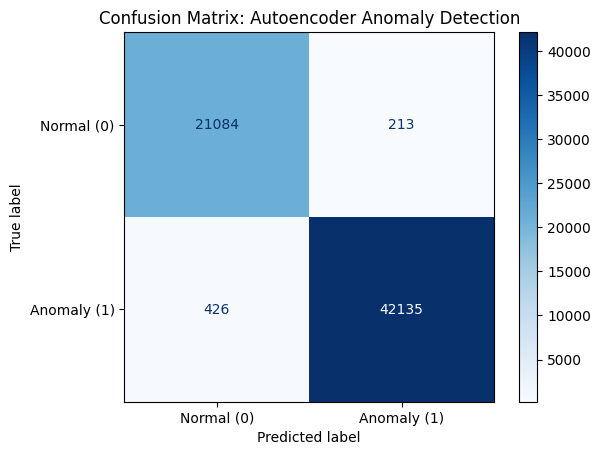

In [143]:
# Set threshold
# threshold_anom = np.percentile(error_norm, 60)
# threshold_anom = best_thresh
threshold_anom = recall_optimized_thresh
threshold_norm = np.percentile(error_norm, 99)
# threshold = 0.5871125778173927
print("Anomaly threshold:", threshold_anom)
print("Normal threshold:", threshold_norm)

# Predict anomalies
autoencoder_preds = np.concatenate([
    (error_norm > threshold_norm).astype(int),     # 0 = normal
    (error_anom > threshold_anom).astype(int)      # 1 = anomaly
])

autoencoder_true = np.concatenate([
    np.zeros_like(error_norm),   # true labels for normal
    np.ones_like(error_anom)     # true labels for anomaly
])

print("\nAutoencoder Performance:")
print(classification_report(autoencoder_true, autoencoder_preds))

# Generate confusion matrix
cm = confusion_matrix(autoencoder_true, autoencoder_preds)

print(f"Confusion Matrix for AutoEncoder:\n{cm}")

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Optional: display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal (0)", "Anomaly (1)"])
disp.plot(cmap=plt.cm.Blues)
# plt.figure(figsize=(10,6))
plt.title("Confusion Matrix: Autoencoder Anomaly Detection")
plt.show()

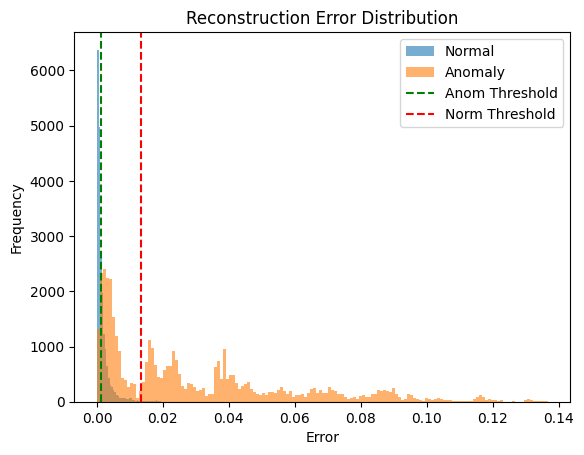

In [126]:
import matplotlib.pyplot as plt

plt.hist(error_norm, bins=150, alpha=0.6, label='Normal')
plt.hist(error_anom, bins=150, alpha=0.6, label='Anomaly')
plt.axvline(threshold_anom, color='green', linestyle='--', label='Anom Threshold')
plt.axvline(threshold_norm, color='red', linestyle='--', label='Norm Threshold')
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

### EVALUATION OF AUTOENCODER

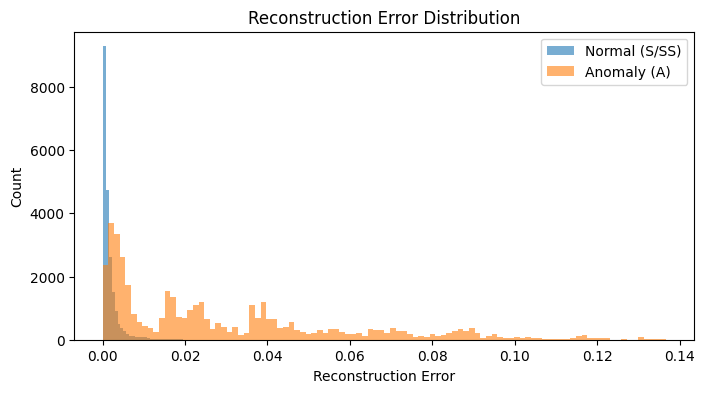

In [113]:
# Optional: Plot
plt.figure(figsize=(8, 4))
plt.hist(error_norm, bins=100, alpha=0.6, label='Normal (S/SS)')
plt.hist(error_anom, bins=100, alpha=0.6, label='Anomaly (A)')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.legend()
plt.show()

In [114]:
from scipy.stats import wasserstein_distance

wd = wasserstein_distance(error_norm, error_anom)
print(f"Wasserstein Distance: {wd:.4f}")

Wasserstein Distance: 0.0279


In [115]:
from scipy.stats import ks_2samp

ks_stat, ks_p = ks_2samp(error_norm, error_anom)
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4e}")

KS Statistic: 0.7072, p-value: 0.0000e+00


In [116]:
from scipy.stats import gaussian_kde

# Estimate PDFs using KDE
kde_norm = gaussian_kde(error_norm)
kde_anom = gaussian_kde(error_anom)

x = np.linspace(min(min(error_norm), min(error_anom)),
                max(max(error_norm), max(error_anom)), 1000)
ovl = np.trapz(np.minimum(kde_norm(x), kde_anom(x)), x)
print(f"Overlap Coefficient (OVL): {ovl:.4f}")

Overlap Coefficient (OVL): 0.2187


In [117]:
from sklearn.metrics import roc_auc_score

errors = np.concatenate([error_norm, error_anom])
labels = np.concatenate([np.zeros(len(error_norm)), np.ones(len(error_anom))])

auc = roc_auc_score(labels, errors)
print(f"ROC-AUC: {auc:.4f}")

ROC-AUC: 0.9315


---

In [119]:
# Full train-test split for supervised classifier
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42)

## XGBoost Classifier


XGBoost Classifier Performance:
              precision    recall  f1-score   support

           A       0.99      0.99      0.99      8403
           S       0.99      0.99      0.99     13373
          SS       0.99      0.99      0.99      8033

    accuracy                           0.99     29809
   macro avg       0.99      0.99      0.99     29809
weighted avg       0.99      0.99      0.99     29809



<Figure size 800x600 with 0 Axes>

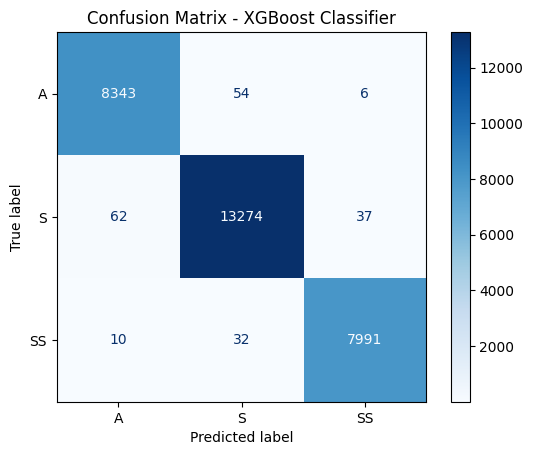

In [120]:
# Train XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train_cls, y_train_cls)

# Predict
y_pred_cls = xgb_clf.predict(X_test_cls)
print("\nXGBoost Classifier Performance:")
print(classification_report(y_test_cls, y_pred_cls, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test_cls, y_pred_cls)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - XGBoost Classifier")
plt.show()

## Logistic Regression

=== Logistic Regression ===
Accuracy: 0.8726
Classification Report:
              precision    recall  f1-score   support

           A       0.86      0.81      0.83      8403
           S       0.88      0.90      0.89     13373
          SS       0.88      0.89      0.89      8033

    accuracy                           0.87     29809
   macro avg       0.87      0.87      0.87     29809
weighted avg       0.87      0.87      0.87     29809



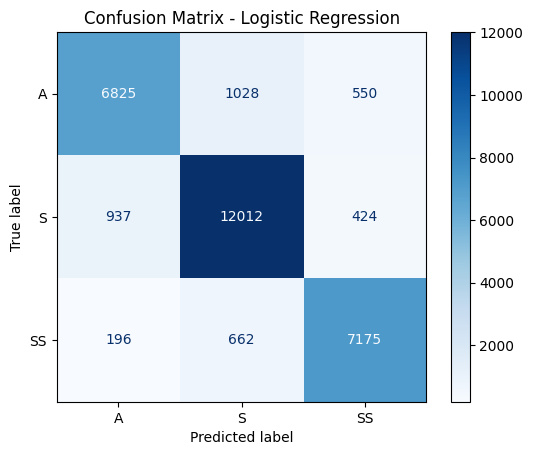

In [121]:
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_cls)
X_test_lr = scaler.transform(X_test_cls)

# Train Logistic Regression
lr_model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000)
lr_model.fit(X_train_lr, y_train_cls)

# Predict
y_pred_lr = lr_model.predict(X_test_lr)

# Evaluation
print("=== Logistic Regression ===")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_lr):.4f}")
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_lr, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## KNN Classifier

=== K-Nearest Neighbors (KNN) ===
Accuracy: 0.9829
Classification Report:
              precision    recall  f1-score   support

           A       0.98      0.98      0.98      8403
           S       0.98      0.98      0.98     13373
          SS       0.99      0.99      0.99      8033

    accuracy                           0.98     29809
   macro avg       0.98      0.98      0.98     29809
weighted avg       0.98      0.98      0.98     29809



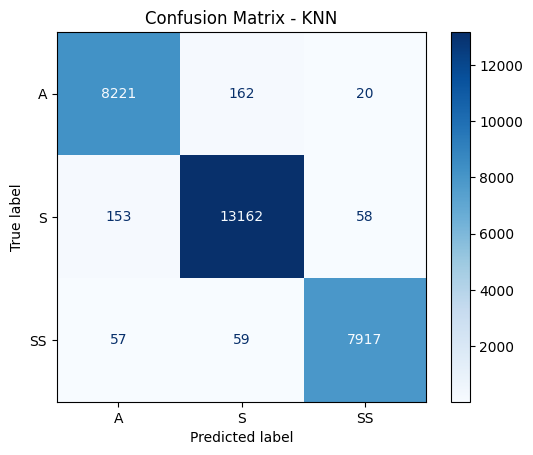

In [122]:
scaler = StandardScaler()
X_train_knn = scaler.fit_transform(X_train_cls)
X_test_knn = scaler.transform(X_test_cls)

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train_cls)

# Predict
y_pred_knn = knn_model.predict(X_test_knn)

# Evaluation
print("=== K-Nearest Neighbors (KNN) ===")
print(f"Accuracy: {accuracy_score(y_test_cls, y_pred_knn):.4f}")
print("Classification Report:")
print(classification_report(y_test_cls, y_pred_knn, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
plt.show()

## COMPARISON OF SUPERVISED CLASSIFIERS

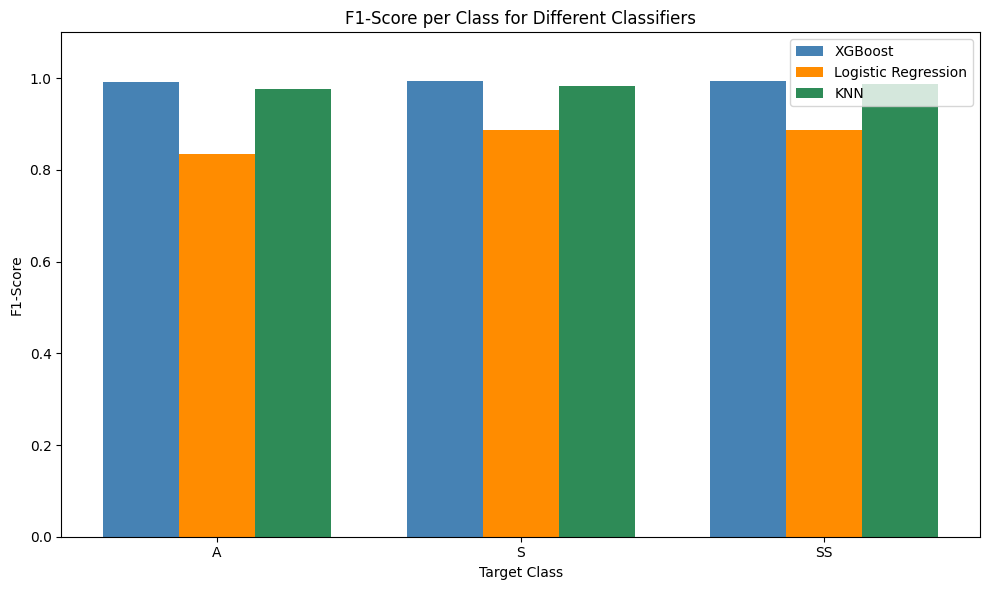

In [123]:
# Compute F1-scores per class
f1_xgb = f1_score(y_test_cls, y_pred_cls, average=None)
f1_lr = f1_score(y_test_cls, y_pred_lr, average=None)
f1_knn = f1_score(y_test_cls, y_pred_knn, average=None)

# Class labels in order of encoding
class_labels = ['A', 'S', 'SS']  # adjust only if your encoding differs

# Bar positions
x = np.arange(len(class_labels))
width = 0.25

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width, f1_xgb, width, label='XGBoost', color='steelblue')
plt.bar(x,        f1_lr,  width, label='Logistic Regression', color='darkorange')
plt.bar(x + width, f1_knn, width, label='KNN', color='seagreen')

# Formatting
plt.xlabel("Target Class")
plt.ylabel("F1-Score")
plt.title("F1-Score per Class for Different Classifiers")
plt.xticks(x, class_labels)  # Use class labels instead of numbers
plt.ylim(0, 1.1)
plt.legend()

plt.tight_layout()
plt.show()
